# Visualize Data

In [103]:
import pandas as pd 
import warnings
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error , mean_absolute_error
import xgboost as xgb
print (xgb.__version__)
import numpy as np
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
warnings.filterwarnings('ignore')



2.1.2


In [104]:
df=pd.read_csv("./data/train.csv")
df_test=pd.read_csv("./data/test.csv")
df.shape,df_test.shape

((177024, 508), (3644, 507))

# Feature Engineering

### Filling missing values

In [ ]:
null_percentage = df.isnull().mean() * 100
columns_to_drop = null_percentage[null_percentage >= 50].index
df=df.drop(columns=columns_to_drop)
df_test=df_test.drop(columns=columns_to_drop)

bg_col=[col for col in df.columns if col.startswith('bg-')]
df[bg_col]=df[bg_col].interpolate(method='linear',axis=1)
df[bg_col]=df[bg_col].fillna(method='bfill',axis=1)
df_test[bg_col]=df_test[bg_col].fillna(method='ffill',axis=1)
df_test[bg_col]=df_test[bg_col].fillna(method='bfill',axis=1)

hr_col=[col  for col in df.columns if col.startswith('hr-')]
df[hr_col]=df[hr_col].fillna(method='ffill',axis=1)
df[hr_col]=df[hr_col].fillna(method='bfill',axis=1)
df_test[hr_col]=df_test[hr_col].interpolate(method='linear',axis=1)
df_test[hr_col]=df_test[hr_col].fillna(method='bfill',axis=1)

inc_col=[col  for col in df.columns if col.startswith('insulin-')]
df[inc_col]=df[inc_col].interpolate(method='linear',axis=1)
df[inc_col]=df[inc_col].fillna(method='bfill',axis=1)
df_test[inc_col]=df_test[inc_col].fillna(method='ffill',axis=1)
df_test[inc_col]=df_test[inc_col].fillna(method='bfill',axis=1)

print(df.shape)
print(df_test.shape)

(177024, 292)
(3644, 291)


In [ ]:
# Initialize and fit the HistGradientBoostingRegressor
model = xgb.XGBRegressor()
model.fit(x_train_split, y_train_split)

# Compute permutation importance with fewer repeats to reduce computation time
result = permutation_importance(model, x_val, y_val, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': result.importances_mean
})

print(feature_importances.describe())


threshold = 0.0005
selected_features = feature_importances[feature_importances['Importance'] > threshold].sort_values(by='Importance', ascending=False)

# Select only the important features for training and validation
x_train_split = x_train_split[selected_features['Feature']]
x_val = x_val[selected_features['Feature']]

# Display selected features
print("Selected Features from Permutation Importance:")
print(selected_features)

### Cumulated Insulin

In [106]:
insulin=df.filter(regex="insulin")
insulin_test=df_test.filter(regex="insulin")

mu = .1
target_x = 2
target_value = 0.8
sigma = np.sqrt(-(target_x - mu)**2 / (2 * np.log(target_value)))
def gaussian(x):
    return  np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
value={}
for col_name in insulin.columns:
    if col_name != "cumulated_insulin":
        x=int(col_name[8:9])+int(col_name[10:12])/60
        value[col_name]=gaussian(x)

cumulated_insulin=[0 for i in range(177024)]
cumulated_insulin_test=[0 for i in range(3644)]
for col_name in insulin.columns:
    if col_name != "cumulated_insulin":
        cumulated_insulin+=np.multiply(insulin[col_name],value[col_name])
        cumulated_insulin_test+=np.multiply(insulin_test[col_name],value[col_name])   

#df=df.drop(columns=df.filter(regex="insulin"))
df["cumulated_insulin"]=cumulated_insulin
df["cumulated_insulin"].fillna(-1,inplace=True)
df_test["cumulated_insulin"]=cumulated_insulin_test
print(cumulated_insulin)

0          1.526658
1          1.589647
2          1.645409
3          1.694081
4          1.735919
            ...    
177019    18.599551
177020    19.250397
177021    19.425045
177022    19.082213
177023    18.753670
Name: insulin-5:55, Length: 177024, dtype: float64


### Sum calories

In [107]:
cals=df.filter(regex="cals")
cals_test=df_test.filter(regex="cals")

sum_cals=cals.sum(axis=1)

#df["sum_cals"]=sum_cals


### Sum steps

In [108]:
steps=df.filter(regex="steps")
steps.fillna(0,inplace=True)
steps_test=df_test.filter(regex="steps")
sum_steps=steps.sum(axis=1)
sum_steps_test=steps_test.sum(axis=1)

#df["sum_steps"]=sum_steps
#df_test["sum_steps"]=sum_steps_test
#print(df["sum_steps"].sort_values())

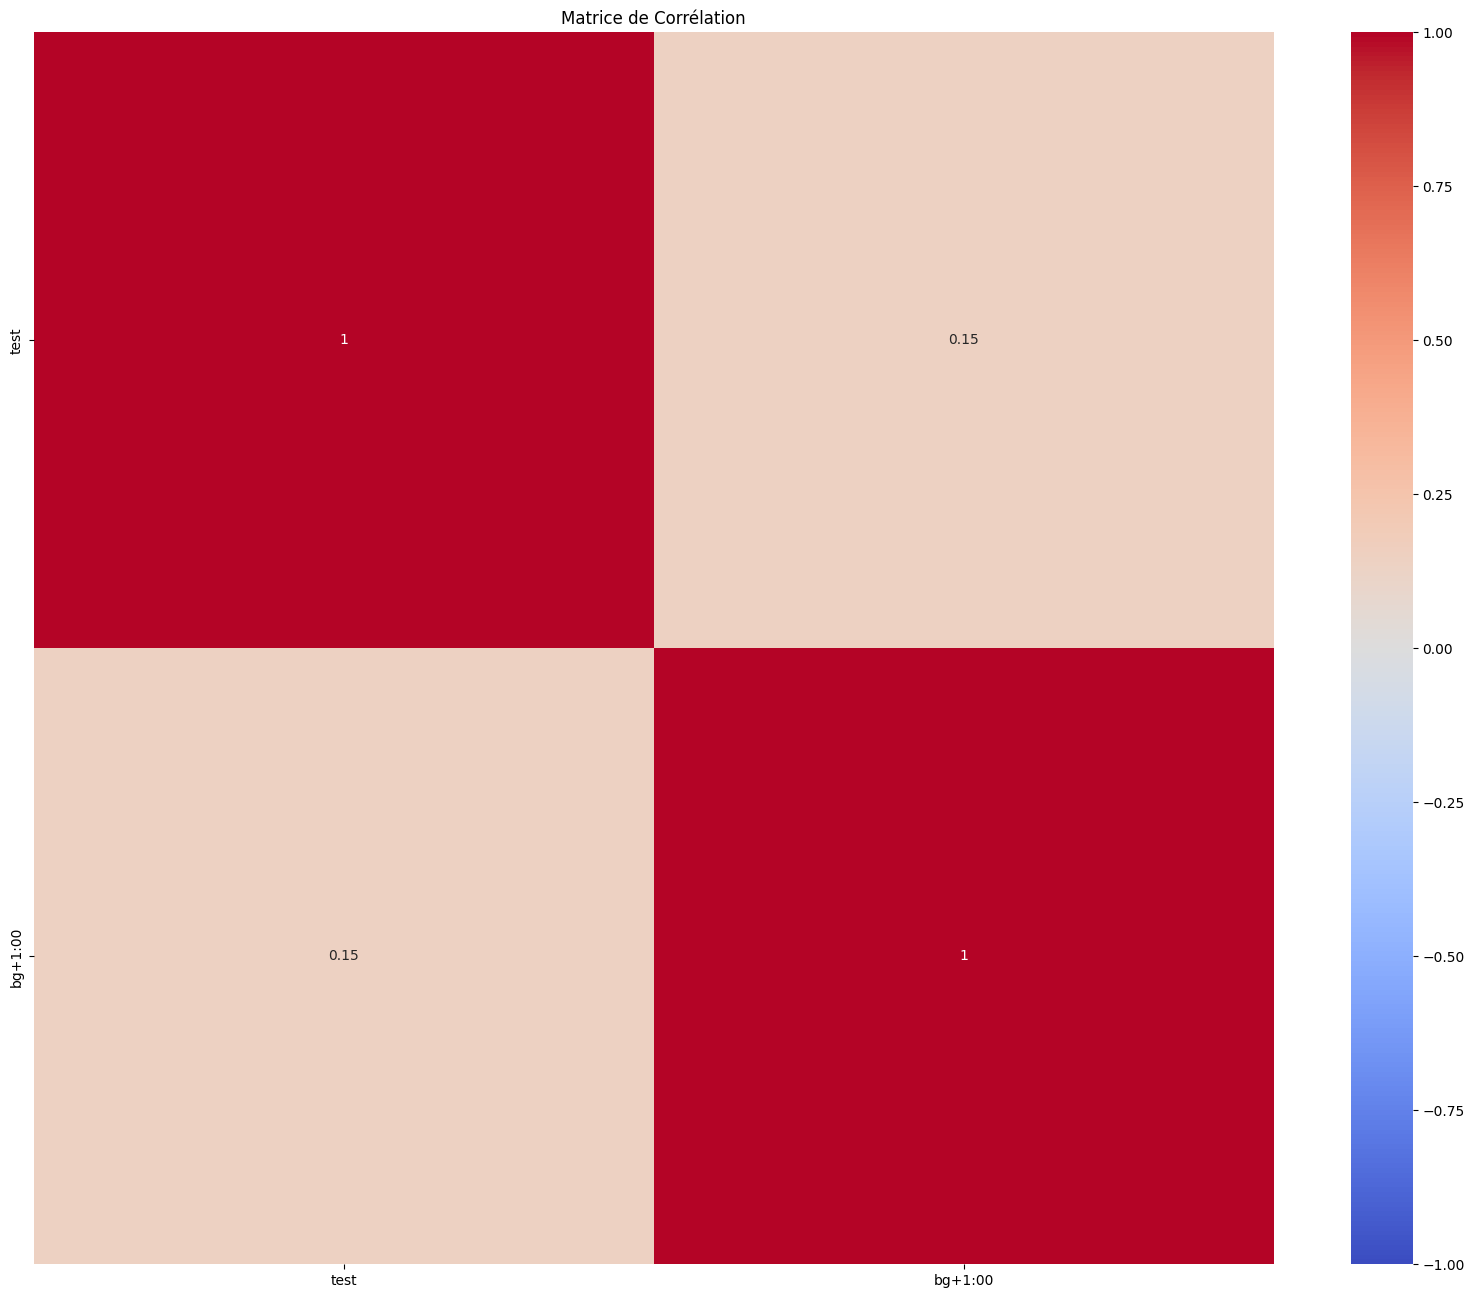

In [109]:
p=pd.DataFrame()
#p=df
#p=p.drop(columns=["id","p_num","time"])
#p=p.filter(regex="cumulated_insulin")
p["test"]=df["cumulated_insulin"]
p["bg+1:00"]=df["bg+1:00"]
correlation=p.corr()

plt.figure(figsize=(20, 16))  # Taille de la figure
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation")
plt.show()

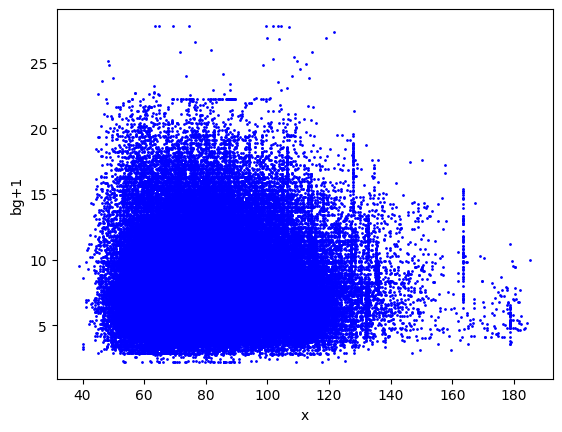

In [110]:
value='hr-0:00'
plot=df[[value,"bg+1:00"]].sort_values(by=value)

x=plot[value]
y=plot["bg+1:00"]
plt.scatter(x, y, color='blue', marker='o',s=1)
plt.xlabel('x')
plt.ylabel('bg+1')
#plt.xlim(0,10)

plt.show()

# XGBoost

### Data Prep

In [111]:
def p_to_int(p_num):
    p=p_num[1:]
    return(int(p))
df['p_num']=df['p_num'].apply(p_to_int)
df_test['p_num']=df_test['p_num'].apply(p_to_int)

In [112]:
df=df.fillna(-1)
df_test=df_test.fillna(-1)
target=df[["p_num","bg+1:00"]]

data=df.drop(columns=["id","bg+1:00","time"])
data=data.drop(columns=df.filter(regex="activity"))
data=data.drop(columns=df.filter(regex="hr"))

### Leave one out

In [ ]:
def LoN(i):
    #separate train/val
    print('p'+str(i))
    x_train,y_train=data[~data['p_num'].isin([i])],target[~target['p_num'].isin([i])]
    x_val,y_val=data[data['p_num'].isin([i])],target[target['p_num'].isin([i])]
    y_train,y_val=y_train.drop(columns=["p_num"]),y_val.drop(columns=["p_num"])
    #x_train,x_val=x_train.drop(columns=["p_num"]),x_val.drop(columns=["p_num"])
    #shuffle
    x_train,y_train=x_train.sample(frac=1, random_state=42).reset_index(drop=True),y_train.sample(frac=1, random_state=42).reset_index(drop=True)
    x_val,y_val=x_val.sample(frac=1, random_state=42).reset_index(drop=True),y_val.sample(frac=1, random_state=42).reset_index(drop=True)
    return x_train,x_val,y_train,y_val

In [71]:
patient=[1,2,3,4,5,6,10,11,12]
models={}
for p in patient:
    x_train,x_val,y_train,y_val=LoN(p)
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=1000,  
        learning_rate=0.1,
        max_depth=6,    
        subsample=0.8,
        colsample_bytree=0.8,
        #eval_metric=root_mean_squared_error,
        early_stopping_rounds=10,
        )
    xgb_model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        verbose=True
        )
    models[p]=xgb_model


p1
[0]	validation_0-rmse:4.00566
[1]	validation_0-rmse:3.85630
[2]	validation_0-rmse:3.73788
[3]	validation_0-rmse:3.61272
[4]	validation_0-rmse:3.51093
[5]	validation_0-rmse:3.45271
[6]	validation_0-rmse:3.37009
[7]	validation_0-rmse:3.31325
[8]	validation_0-rmse:3.27875
[9]	validation_0-rmse:3.23729
[10]	validation_0-rmse:3.21400
[11]	validation_0-rmse:3.19816
[12]	validation_0-rmse:3.17492
[13]	validation_0-rmse:3.15262
[14]	validation_0-rmse:3.13745
[15]	validation_0-rmse:3.12297
[16]	validation_0-rmse:3.14034
[17]	validation_0-rmse:3.16120
[18]	validation_0-rmse:3.14951
[19]	validation_0-rmse:3.13764
[20]	validation_0-rmse:3.12771
[21]	validation_0-rmse:3.13740
[22]	validation_0-rmse:3.14426
[23]	validation_0-rmse:3.13933
[24]	validation_0-rmse:3.13109
[25]	validation_0-rmse:3.12544
p2
[0]	validation_0-rmse:3.01684
[1]	validation_0-rmse:2.87910
[2]	validation_0-rmse:2.76905
[3]	validation_0-rmse:2.67739
[4]	validation_0-rmse:2.59821
[5]	validation_0-rmse:2.54875
[6]	validation_0-r

In [90]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

mux=Sequential([
    #layers.Input((9,1)),
    layers.Dense(9,activation='relu'),
    layers.Dense(9,activation='relu'),
    layers.Dense(1)
])

mux.compile(loss='mse',optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError])

In [91]:
target_model=target.drop(columns=["p_num"])
pred_model=pd.DataFrame(columns=patient)

for p, model in models.items():
    y_pred = model.predict(data)
    pred_model[p]=y_pred

x_train,x_val,y_train,y_val=train_test_split(pred_model, target_model, test_size=0.2, random_state=42)
x_train,x_val = np.array(x_train),np.array(x_val)
y_train,y_val=np.array(y_train),np.array(y_val)

print(x_train.shape,y_train.shape)

(141619, 9) (141619, 1)


In [92]:
mux.fit(x_train,y_train,
          validation_data=(x_val,y_val),
          epochs=10,
          batch_size=32)

Epoch 1/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 4s 796us/step - loss: 12.2108 - root_mean_squared_error: 3.3119 - val_loss: 3.7010 - val_root_mean_squared_error: 1.9238
Epoch 2/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 3s 742us/step - loss: 3.6028 - root_mean_squared_error: 1.8980 - val_loss: 3.5769 - val_root_mean_squared_error: 1.8913
Epoch 3/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 3s 738us/step - loss: 3.4935 - root_mean_squared_error: 1.8691 - val_loss: 3.4935 - val_root_mean_squared_error: 1.8691
Epoch 4/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 3s 726us/step - loss: 3.4114 - root_mean_squared_error: 1.8470 - val_loss: 3.4259 - val_root_mean_squared_error: 1.8509
Epoch 5/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 3s 728us/step - loss: 3.3374 - root_mean_squared_error: 1.8268 - val_loss: 3.3835 - val_root_mean_squared_error: 1.8394
Epoch 6/10
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 3s 755us/step - loss: 3.3339 - root_mean_squared_error: 1.8259 - val_loss: 3.3539 - val_root_mean_squared_error: 1.8314
Epoch 7/10
4426/4426 ━━━━━━

In [ ]:
profiles={}
for e in patient:
    profiles["p"+e]=data[data['p_num'].isin(['p'+e])].drop(columns="p_num").mean()


In [78]:
import numpy as np

def softmax(x,t):
    e_x = np.exp(-x/t)
    return e_x / e_x.sum(axis=0)


def compute_distances(x):
    x_val_mean=x.mean()
    distances = pd.DataFrame(index=["distance"])
    for e in profiles:
        distance=np.sqrt(np.power(profiles[e]-x_val_mean,2).sum())
        distances[e]=distance
    row=distances.loc['distance']
    distances.loc['distance']=(row- row.min()) / (row.max() - row.min())
    distances.loc['distance']=softmax(distances.loc['distance'],.3)
    #print(distances)
    return(distances)

In [101]:
_,x_val,_,y_val=LoN(11)
pred=pd.DataFrame()
#distances=compute_distances(x_val)
for p, model in models.items():
    #distance=distances.at['distance','p'+p, ] 
    y_pred = model.predict(x_val)
    #pred[p]=distance*y_pred
    pred[p]=y_pred
pred_model=mux.predict(pred).flatten()
print(pred_model)
pred_mean=pred.mean(axis=1)
#pred_mean=pred.sum(axis=1)
rmse=root_mean_squared_error(y_val, pred_model)
print(rmse)

p11
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
[ 6.3973036 12.350696  13.233647  ...  9.356027  10.2632265  6.069836 ]
1.8887178582676687


# Submission CSV

In [113]:
data_test=df_test.drop(columns=["id","time"])
data_test=data_test.drop(columns=df.filter(regex="activity"))
data_test=data_test.drop(columns=df.filter(regex="hr"))

### Enhanced method

In [29]:
p_num=data_test["p_num"]
unique_p=[]
for e in p_num:
    if e not in unique_p:
        unique_p.append(e)

p_pred={}
for e in unique_p:
    x_test=data_test[data_test['p_num'].isin([e])].drop(columns="p_num")
    distances=compute_distances(x_test)
    
    pred=pd.DataFrame()
    for p, model in models.items():   
        distance=distances.at['distance','p'+p, ] 
        y_pred = model.predict(x_test)
        pred[p]=distance*y_pred
    
    p_pred[e]=pred.sum(axis=1)
concatenated = pd.concat([p_pred[e] for e,value in p_pred.items()], axis=0).reset_index(drop=True)
print(concatenated)



KeyError: 'p_num'

In [86]:
print(concatenated[concatenated.index.duplicated()])
results={"id":df_test["id"],"bg+1:00":concatenated}
submission=pd.DataFrame(results)
print(submission.shape)
submission.to_csv('submission.csv', index=False, encoding='utf-8')

Series([], dtype: float64)
(3644, 2)


### Ensemble classic method

In [114]:
pred=pd.DataFrame()
for p, model in models.items():   
    y_pred = model.predict(data_test)
    pred[p]=y_pred
pred_model=mux.predict(pred).flatten()
pred_mean=pred.mean(axis=1)
print(pred_model)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
[8.3675995 5.24506   7.382065  ... 6.704534  8.961242  6.524206 ]


In [115]:
#results={"id":df_test["id"],"bg+1:00":y_pred_test}
results={"id":df_test["id"],"bg+1:00":pred_model}
submission=pd.DataFrame(results)
print(submission.shape)
submission.to_csv('submission.csv', index=False, encoding='utf-8')

(3644, 2)
